In [1]:
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.model_selection import cross_val_score
from sklearn import datasets, decomposition,manifold
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
import warnings 


plt.rcParams['font.family'] = 'SimHei'     ### # matplotlib其实是不支持显示中文的 显示中文需要一行代码设置字体
plt.rcParams['axes.unicode_minus'] = False
warnings.filterwarnings ('ignore')  ### 忽略版本警告

In [2]:
# # 读取并查看数据
# data = pd.read_csv(r"digit recognizor.csv")
# X = data.iloc[:,1:]
# y = data.iloc[:,0]
# print(X.shape)

#加载数据，显示数据
digits = datasets.load_digits()
X = digits.data
y = digits.target
print (X.shape,y.shape)


(1797, 64) (1797,)


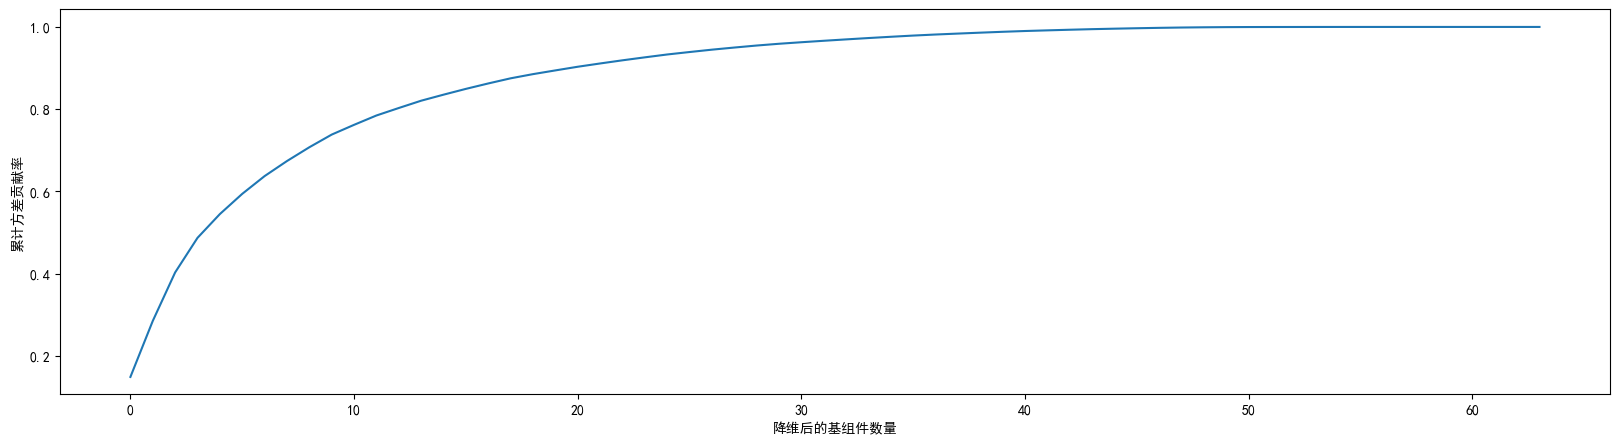

In [3]:
# 画累计方差贡献率曲线，找最佳降维后维度的范围
pca_line = PCA().fit(X)
plt.figure(figsize=[20,5])
plt.plot(np.cumsum(pca_line.explained_variance_ratio_))
plt.xlabel("降维后的基组件数量")
plt.ylabel("累计方差贡献率")
plt.show()

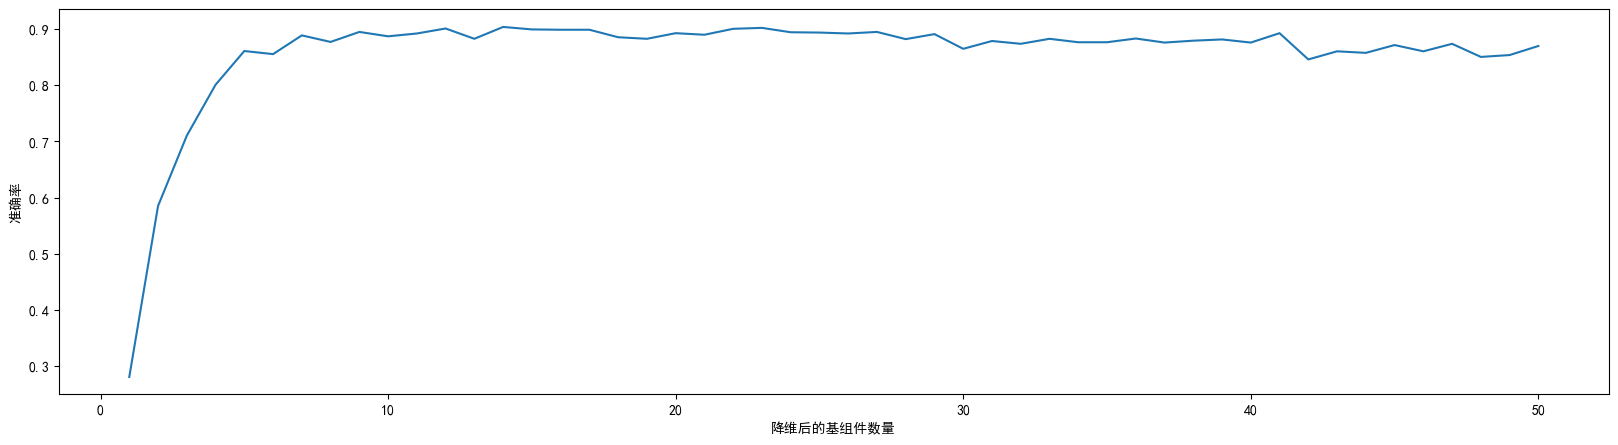

12.560771465301514


In [4]:
#降维后维度的学习曲线，继续缩小最佳维度的范围
time_start = time.time()
score = []
for i in range(1,51):
    X_pca = PCA(i).fit_transform(X)
    once = cross_val_score(RFC(n_estimators=10,random_state=0),X_pca,y,cv=5).mean()
    score.append(once)
plt.figure(figsize=[20,5])
plt.plot(range(1,51),score)
plt.xlabel("降维后的基组件数量")
plt.ylabel("准确率")
plt.show()
time_end = time.time()
time_sum = time_end - time_start
print(time_sum)

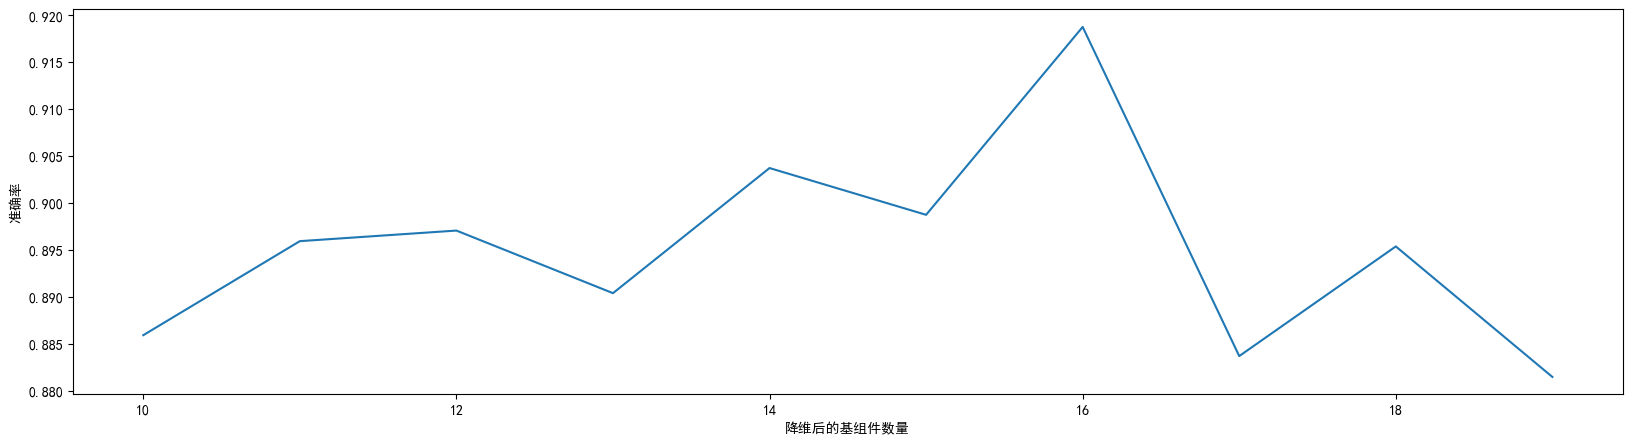

In [5]:
#细化学习曲线，找出降维后的最佳维度
score = []
for i in range(10,20):
    X_pca = PCA(i).fit_transform(X)
    once = cross_val_score(RFC(n_estimators=10,random_state=0),X_pca,y,cv=5).mean()
    score.append(once)
plt.figure(figsize=[20,5])
plt.xlabel("降维后的基组件数量")
plt.ylabel("准确率")
plt.plot(range(10,20),score)
plt.show()

In [6]:
#导入找出的最佳维度进行降维，查看模型效果
X_pca = PCA(16).fit_transform(X) # 64 列特征变为 16 列特征
print(cross_val_score(RFC(n_estimators=100,random_state=0),X_pca,y,cv=5).mean()) # 使用随机森林进行交叉验证

0.9282342927886104


In [7]:
# 使用默认的KNN参数，看到在交叉验证环节使用KNN是否比随机森林好
print(cross_val_score(KNN(),X_pca,y,cv=5).mean()) # 结果是KNN好

0.9593980191891054


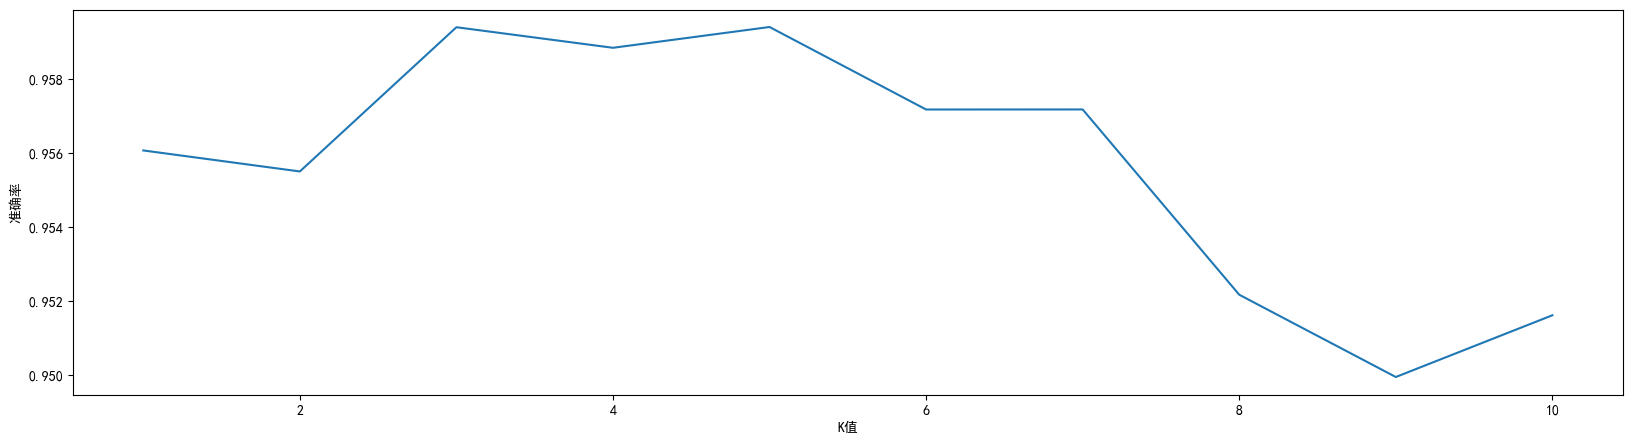

1.1747395992279053


In [8]:
# KNN的K值学习曲线
time_start = time.time()
score = []
for i in range(10):
    X_dr = PCA(16).fit_transform(X)
    once = cross_val_score(KNN(i+1),X_pca,y,cv=5).mean()
    score.append(once)
plt.figure(figsize=[20,5])
plt.xlabel("K值")
plt.ylabel("准确率")
plt.plot(range(1,11),score)
plt.show()
time_end = time.time()
time_sum = time_end - time_start
print(time_sum)

In [9]:
#K值优化后的交叉验证
print(cross_val_score(KNN(5),X_pca,y,cv=5).mean())

0.9593980191891054


In [10]:
##################################################################################################################################

In [11]:
# 由之前的实验可知t-SNE在手写数据集上效果良好

In [12]:
# 默认参数下的t-SNE - n_components 小于4，维度不能超过4
tsne = manifold.TSNE(n_components=3, init='pca', random_state=0, perplexity=10)
X_tsne = tsne.fit_transform(X)
print (X_tsne.shape)
print(cross_val_score(KNN(),X_tsne,y,cv=5).mean())

(1797, 3)
0.972742185082018


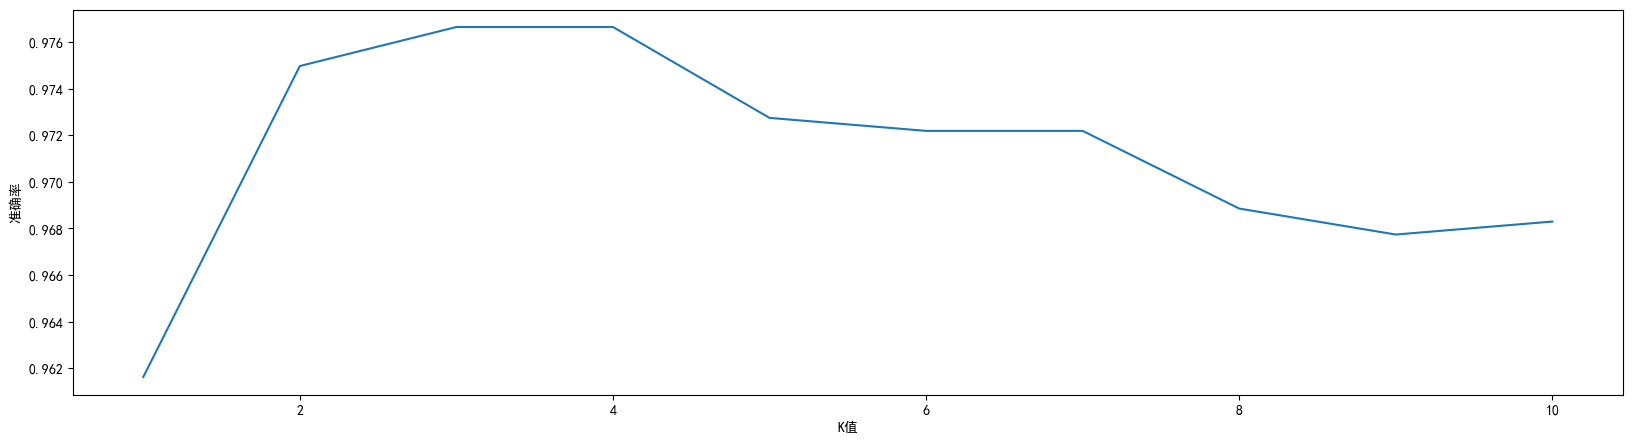

0.5395219326019287


In [13]:
# KNN的K值学习曲线
time_start = time.time()
score = []
for i in range(10):
    once = cross_val_score(KNN(i+1),X_tsne,y,cv=5).mean()
    score.append(once)
plt.figure(figsize=[20,5])
plt.xlabel("K值")
plt.ylabel("准确率")
plt.plot(range(1,11),score)
plt.show()
time_end = time.time()
time_sum = time_end - time_start
print(time_sum)

In [14]:
#K值优化后的交叉验证
print(cross_val_score(KNN(3),X_tsne,y,cv=5).mean())

0.9766419065304859


In [15]:
#############################################################################################################################

In [16]:
# 尝试LLE以下使用10作默认的邻居数
clf = manifold.LocallyLinearEmbedding(n_neighbors=10, n_components=2,method='standard')
X_lle = clf.fit_transform(X)
print(cross_val_score(KNN(),X_lle,y,cv=5).mean())

0.9026385020117612


In [17]:
# 画学习曲线，找出降维后的最佳维数和邻居数
# 单线程太慢，下面使用多线程加速
# best_list = [] #(维数，邻居数，交叉验证的准确率)
# for i in range(2,64): # 维数
#     score = []
#     for j in range(3, 20): # 邻居数
#         clf = manifold.LocallyLinearEmbedding(n_neighbors=j, n_components=i,method='standard')
#         X_lle = clf.fit_transform(X)
#         once = cross_val_score(KNN(),X_lle,y,cv=5).mean()
#         score.append(once)
#     best_list.append((i,score.index(max(score)),max(score)))
# print(best_list)

In [18]:
# 多线程参数调优
# 多线程判断求解
import threading
import queue
from tqdm import tqdm

time_start = time.time()
g = queue.Queue()
result_g = queue.Queue()

count = 0
for i in range(2,64): # 维数
    for j in range(3, 20): # 邻居数
        g.put((i,j))
        count += 1

def temp_g():
    while True:
        if g.qsize() != 0:
            elem = g.get()
            i = elem[0]
            j = elem[1]
            clf = manifold.LocallyLinearEmbedding(n_neighbors=j, n_components=i,method='standard')
            X_lle = clf.fit_transform(X)
            once = cross_val_score(KNN(),X_lle,y,cv=5).mean()
            result_g.put((i, j, once))
        else:
            break

threads = []
for i in tqdm(range(g.qsize())):
    t = threading.Thread(target=temp_g)
    threads.append(t)
    t.start()

print('主程序运行中...')

# 等待所有线程任务结束。
for t in threads:
    t.join()

print("所有线程任务完成")

# 栈反解数据列表
result_list = []
for i in range(result_g.qsize()):
    j = result_g.get()
    result_list.append(j)
result_list.sort(key=lambda x:x[2]) # 乱序排序

print(result_list[0:20])
time_end = time.time()
time_sum = time_end - time_start
print(time_sum) # 结果是跑了2054秒，时间成本很高

100%|██████████████████████████████████████████████████████████████████████████████| 1054/1054 [15:30<00:00,  1.13it/s]


主程序运行中...
所有线程任务完成
[(2, 18, 0.6561173011451562), (2, 19, 0.6845017022593625), (2, 17, 0.6895187248529868), (4, 5, 0.714535747446611), (2, 16, 0.7390560198081089), (2, 13, 0.7585267718972454), (2, 14, 0.7612999071494894), (2, 15, 0.7657582791705355), (3, 19, 0.7663030021665118), (3, 17, 0.7724295883627359), (3, 18, 0.7807520891364902), (4, 17, 0.8069204580625193), (4, 19, 0.8130578768183223), (3, 15, 0.8152615289384091), (3, 16, 0.8202940266171463), (2, 9, 0.8391999380996594), (2, 12, 0.8441906530485916), (4, 18, 0.8441999380996595), (3, 14, 0.8458650572578149), (2, 8, 0.8503265242958836)]
2054.643949985504


In [23]:
print(result_list[-1]) #最好的参数配置 维数 邻居数 准确率

(18, 6, 0.9771959145775302)


In [25]:
#导入找出的最佳邻居数进行降维，查看模型效果
clf = manifold.LocallyLinearEmbedding(n_neighbors=6, n_components=18,method='standard')
X_lle = clf.fit_transform(X)
print(cross_val_score(KNN(),X_lle,y,cv=5).mean()) # 较未调参好了

0.9771959145775302


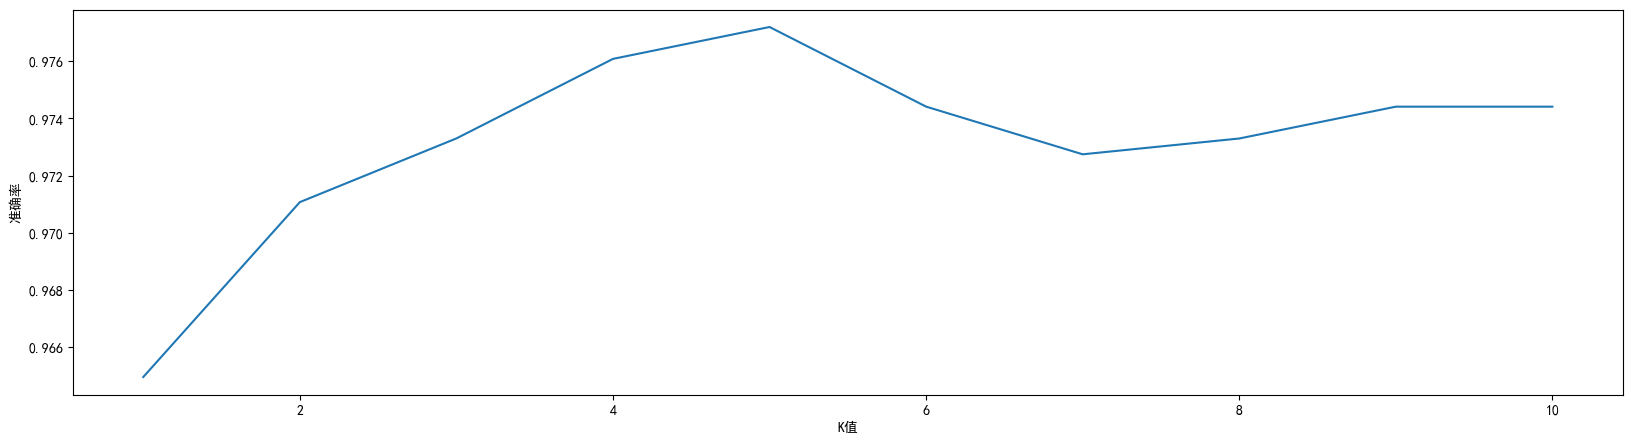

1.074317455291748


In [26]:
# KNN的K值学习曲线
time_start = time.time()
score = []
for i in range(10):
    once = cross_val_score(KNN(i+1),X_lle,y,cv=5).mean()
    score.append(once)
plt.figure(figsize=[20,5])
plt.xlabel("K值")
plt.ylabel("准确率")
plt.plot(range(1,11),score)
plt.show()
time_end = time.time()
time_sum = time_end - time_start
print(time_sum)

In [27]:
#K值优化后的交叉验证
print(cross_val_score(KNN(5),X_lle,y,cv=5).mean())

0.9771959145775302


In [22]:
# 总结，模型优劣：LLE > t-SNE > PCA ，以上为优化后的结果，实际LLE比t-SNE好0.0017，提升不大
# t-SNE维度受限(3维)，PCA(16维)和LLE(18维)会比较适合一点，数据集要保留的数据量更大
# 其中LLE为了调成最优时间成本很高(花了2005秒)，综合来看PCA会在准确率，数据量以及时间成本上更合适